# TADI: Practical work 2
## Deformable models
### Sorbonne Université 2024
### GRUSS Carlos, RCHAKI Oussama

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import platform
# necessite scikit-image 
import skimage
from skimage import io as skio
from skimage import segmentation
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import checkerboard_level_set
from skimage.segmentation import disk_level_set
from skimage.draw import disk as draw_disk
from skimage.morphology import disk
from skimage import morphology as morpho

## General comments

For the code to work, all the images used need to be on the same directory as this notebook. The Python and library versions used are listed below.

In [2]:
print('Python version: ' + platform.python_version())
print('Numpy version: ' + np.__version__)
print('Scikit-image version: ' + skimage.__version__)

Python version: 3.12.3
Numpy version: 1.26.4
Scikit-image version: 0.24.0


## Parametric active contours

### Parameters

The scikit-image ``active_contour`` deformable model has the following parameters we can tune:

- **alpha:** Snake length shape parameter. Higher values makes snake contract faster. 
- **beta:** Snake smoothness shape parameter. Higher values makes snake smoother. 
- **w_line:** Controls attraction to brightness. Use negative values to attract toward dark regions.
- **w_edge:** Controls attraction to edges. Use negative values to repel snake from edges.
- **gamma:** Explicit time stepping parameter. 
- **boundary_condition:** Boundary conditions for the contour. Can be one of ‘periodic’, ‘free’, ‘fixed’, ‘free-fixed’, or ‘fixed-free’. 
    - ‘periodic’ attaches the two ends of the snake.
    - ‘fixed’ holds the end-points in place.
    - ‘free’ allows free movement of the ends.

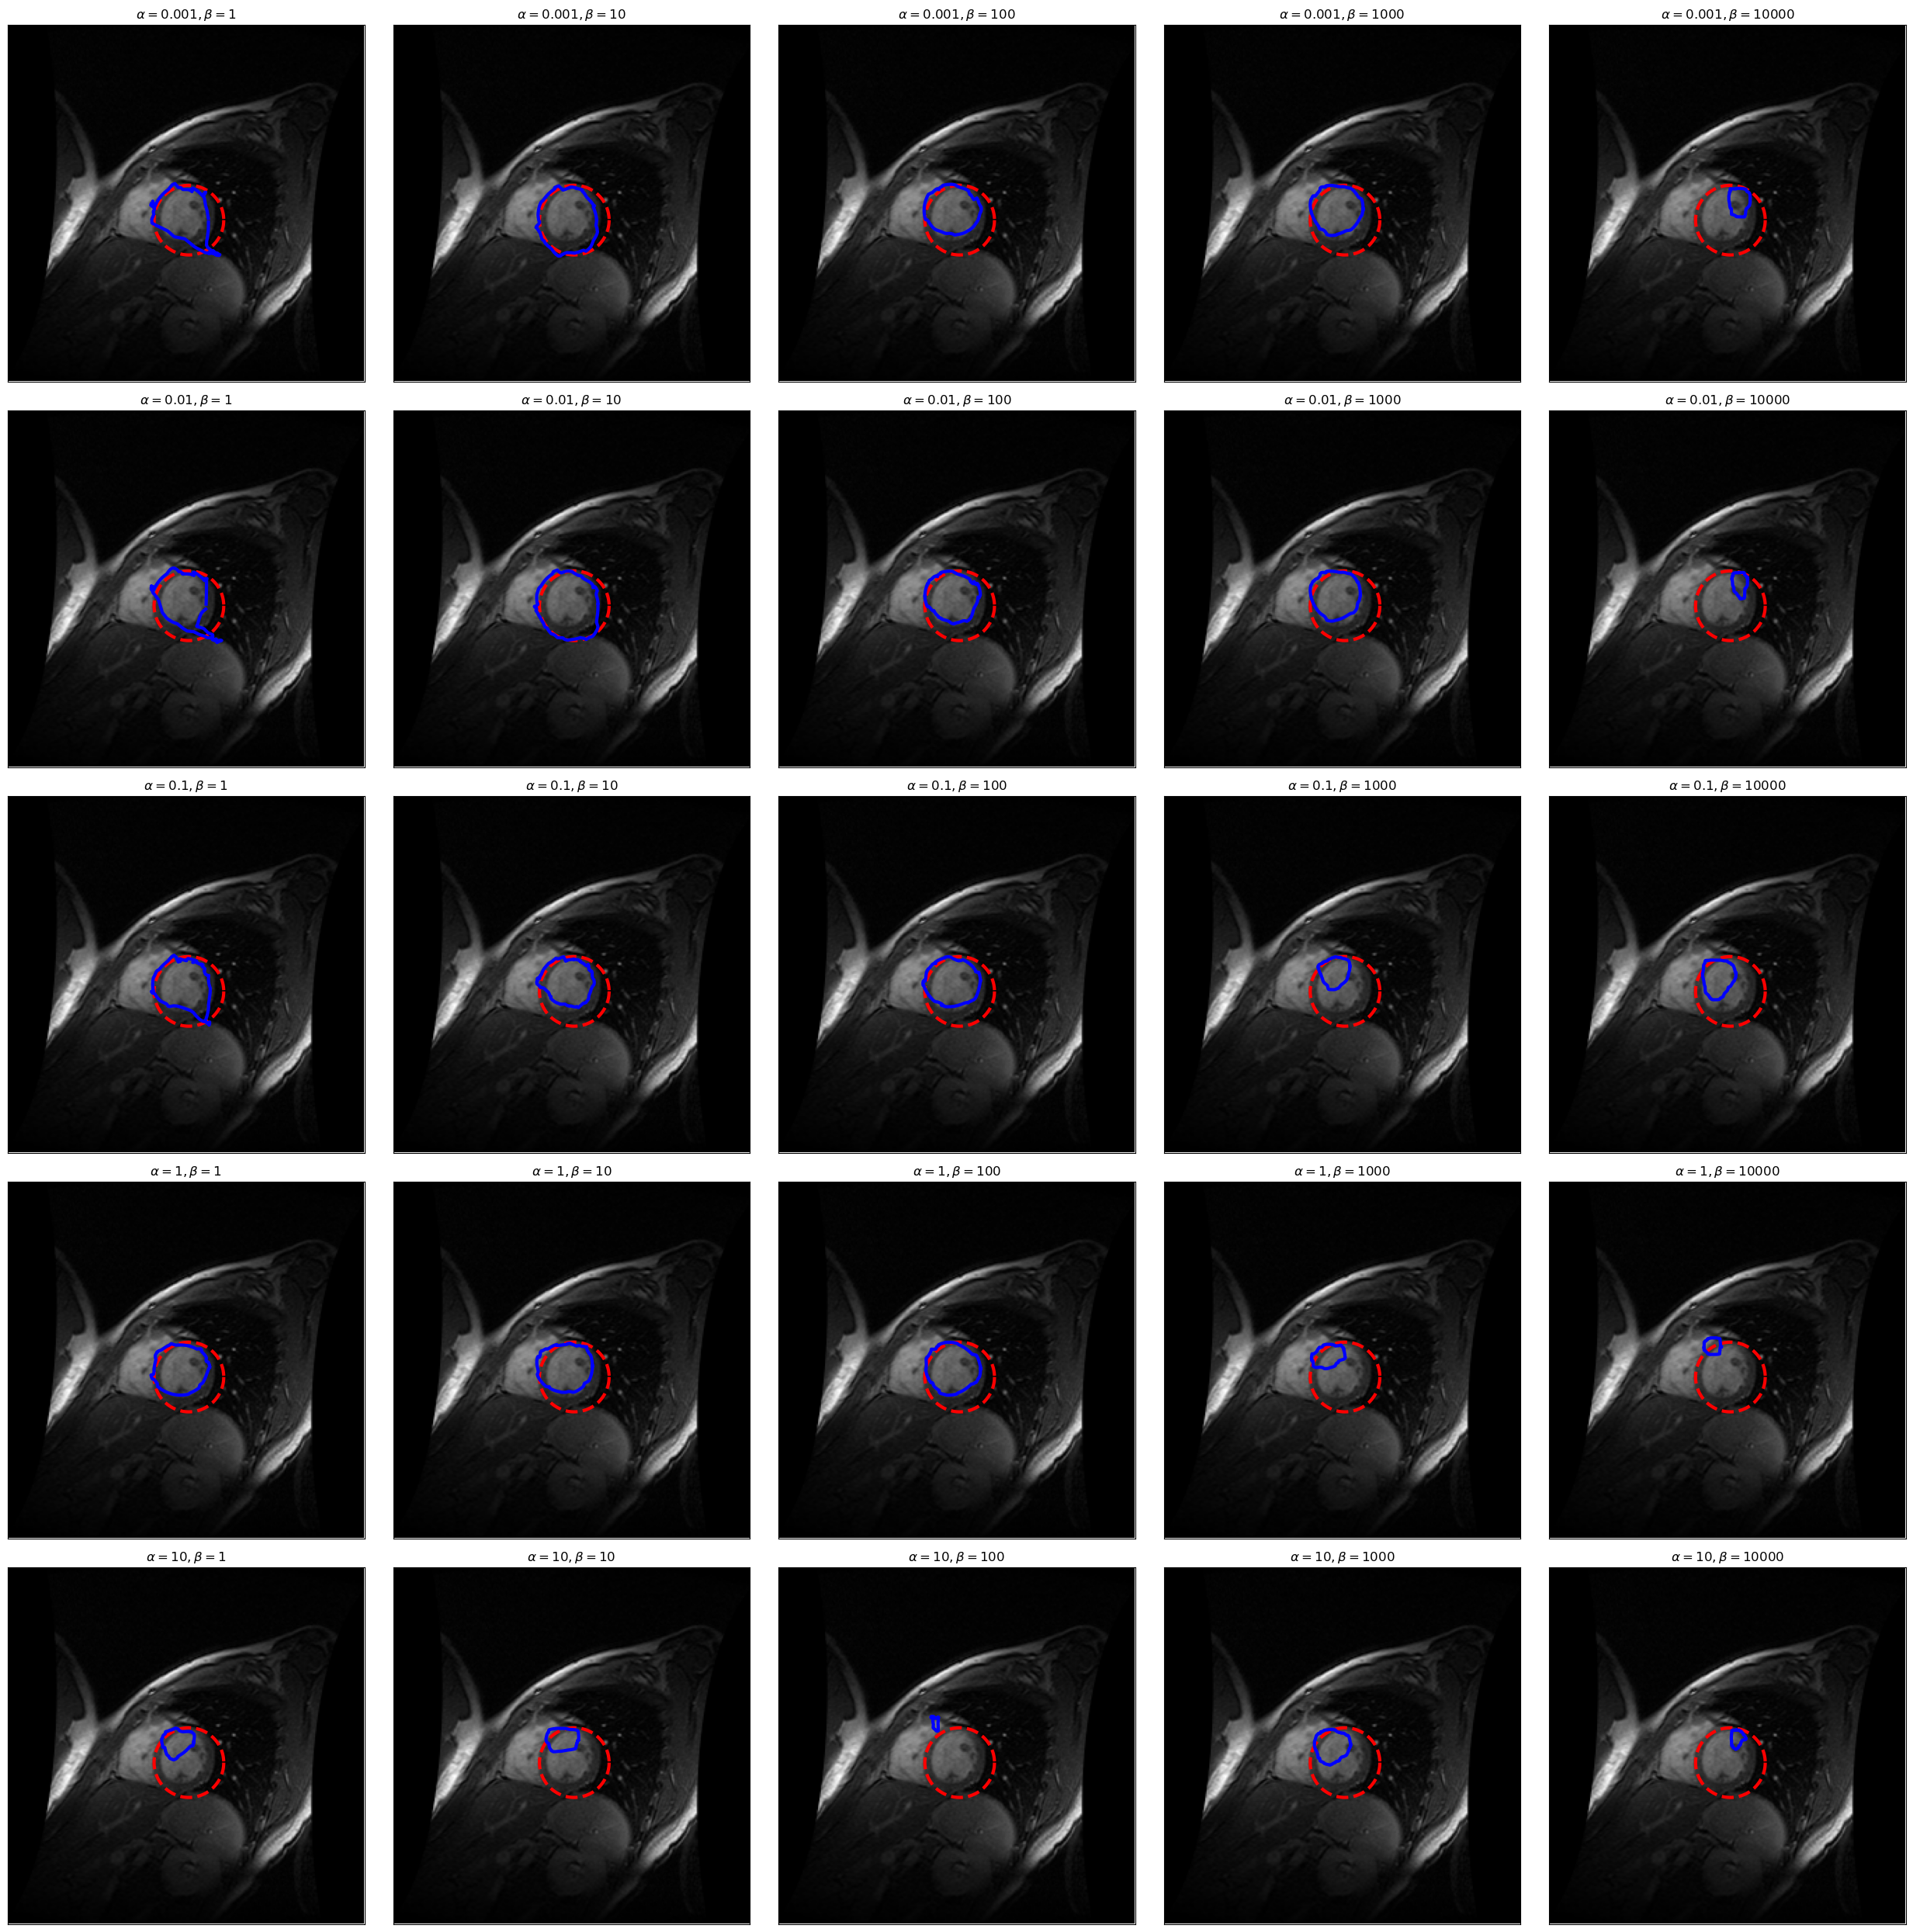

In [3]:
im = skio.imread('coeurIRM.bmp')

s = np.linspace(0, 2*np.pi, 100)
r = 140 + 25*np.sin(s)
c = 130 + 25*np.cos(s)
init = np.array([r, c]).T

alphas = [0.001, 0.01, 0.1, 1, 10]
betas = [1, 10, 100, 1000, 10000]

fig, axes = plt.subplots(5, 5, figsize=(25, 25))

for i, alpha in enumerate(alphas):
    for j, beta in enumerate(betas):
        snake = active_contour(gaussian(im, 3),
                               init, alpha=alpha, beta=beta, w_edge=50, gamma=0.001)
        ax = axes[i, j]
        ax.imshow(im, cmap=plt.cm.gray)
        ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
        ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, im.shape[1], im.shape[0], 0])
        ax.set_title(r'$\alpha = {}, \beta = {}$'.format(alpha, beta))

plt.tight_layout()
plt.show()

In the previous plot, we observe the results of the same initialization when varying the values of ``alpha`` and ``beta``. On the one hand, ``alpha`` can be interpreted as the "elasticity" coefficient of the curve, a lower value makes it harder for the snake to deform and can slow down convergence. On the other hand, ``beta`` can be interpreted as the "stiffness" coefficient of the snake. Decreasing this value can speed up convergence and provide somewhat smoother results.

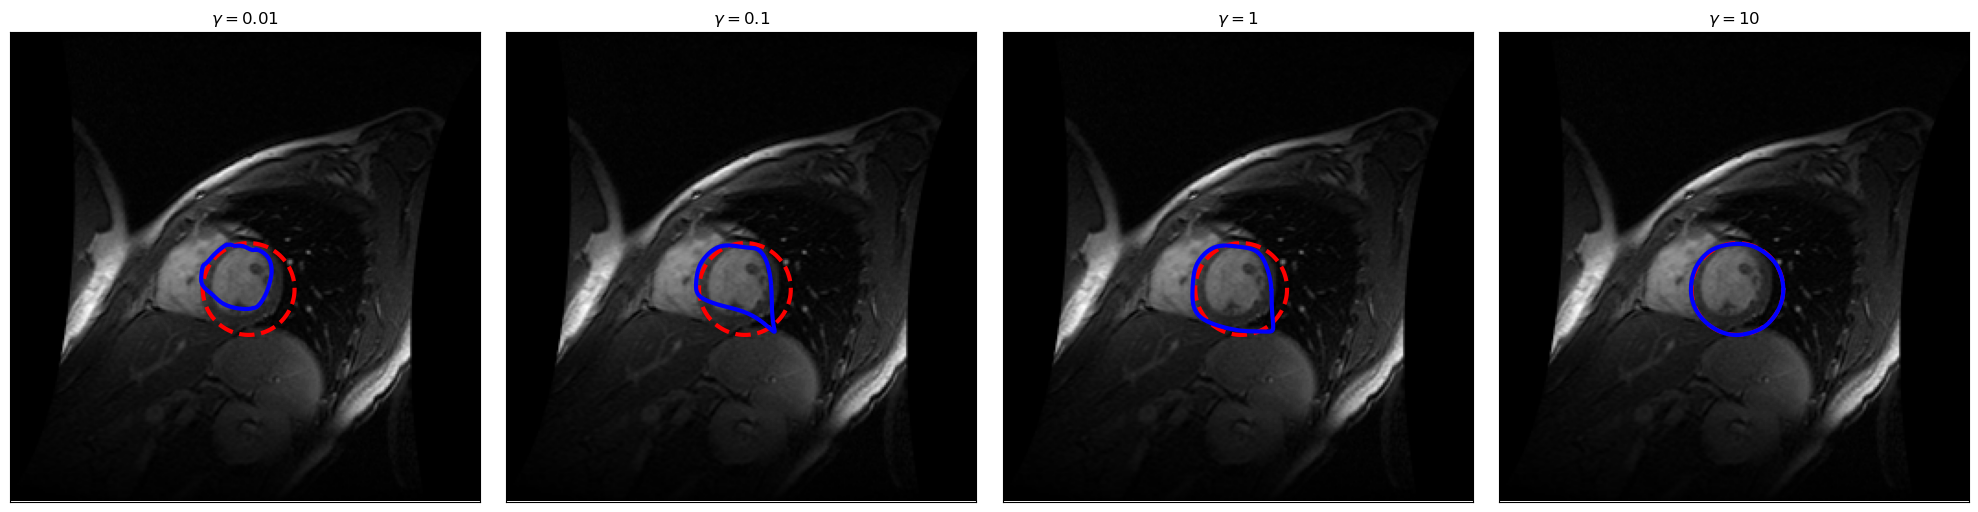

In [4]:
# For fixed parameters, vary the value of gamma and plot the results
gammas = [0.01, 0.1, 1, 10]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, gamma in enumerate(gammas):
    snake = active_contour(gaussian(im, 3),
                           init, alpha=0.001, beta=10, w_edge=50, gamma=gamma)
    ax = axes[i]
    ax.imshow(im, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, im.shape[1], im.shape[0], 0])
    ax.set_title(r'$\gamma = {}$'.format(gamma))

plt.tight_layout()
plt.show()

For this plot, we fixed ``alpha`` and ``beta`` and observe how the obtained segmentation varies based on the value of ``gamma``. This parameter can be interpreted as the "viscocity" of the medium, or how fast the curve can adapt. Increasing this value can help regularize the segmentations, but setting it too high might not allow the curve to adapt fast enough to converge to anything useful.

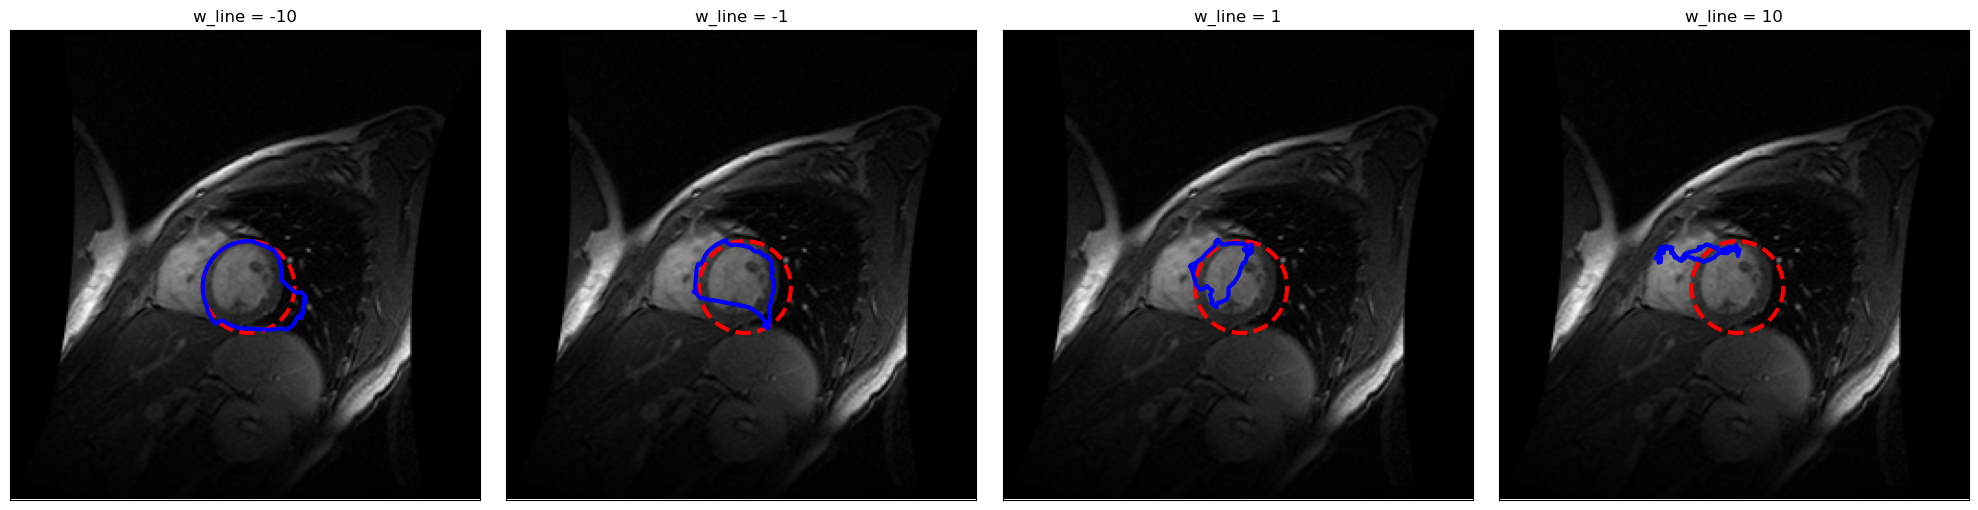

In [5]:
# For fixed parameters, vary the value of w_line and plot the results

w_lines = [-10, -1, 1, 10]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, w_line in enumerate(w_lines):
    snake = active_contour(gaussian(im, 3),
                           init, alpha=0.001, beta=10, w_edge=50, gamma=0.001, w_line=w_line)
    ax = axes[i]
    ax.imshow(im, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, im.shape[1], im.shape[0], 0])
    ax.set_title(r'w_line = {}'.format(w_line))

plt.tight_layout()
plt.show()

In the previous figure we observe the effects of varying the value of ``w_line``, which controls the external forces on the contour attracting the contour to bright/dark areas. 

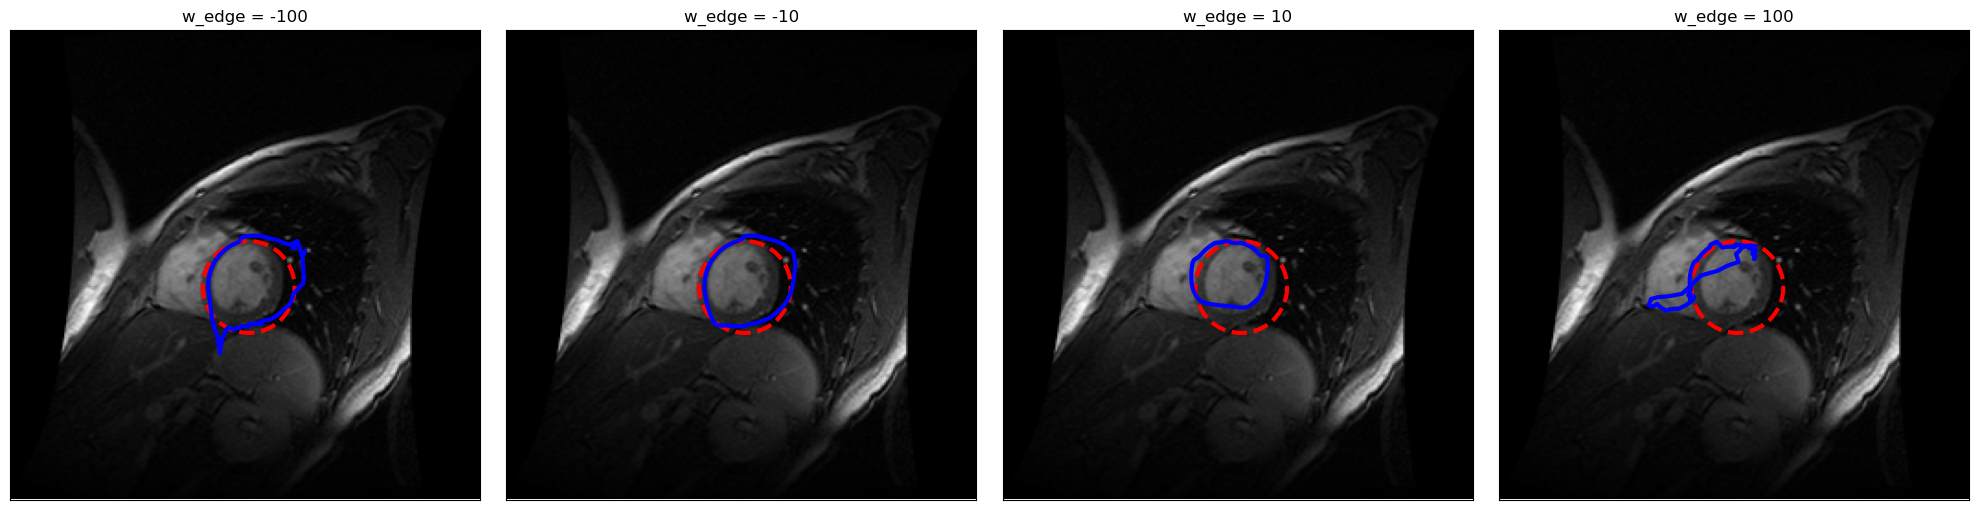

In [6]:
# For fixed parameters, vary the value of w_edge and plot the results

w_edges = [-100, -10, 10, 100]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, w_edge in enumerate(w_edges):
    snake = active_contour(gaussian(im, 3),
                           init, alpha=0.001, beta=10, w_edge=w_edge, gamma=0.001)
    ax = axes[i]
    ax.imshow(im, cmap=plt.cm.gray)
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, im.shape[1], im.shape[0], 0])
    ax.set_title(r'w_edge = {}'.format(w_edge))

plt.tight_layout()
plt.show()

In the previous figure we observe the effects of varying the value of ``w_edge``, which controls the external forces on the contour attracting/repelling the contour to edges. 

### Segmentation

We will try to design a pipeline which receives an transverse MRI of a brain and is capable of segmenting the boundary between the background and the skull, and then using this segmentation, obtain a segmentation of the brain.

In [7]:
def segment_brain(file_name):
    im=skio.imread(file_name, as_gray=True)
    im = img_as_float(im)

    # Convert to grayscale
    if len(im.shape) == 3:
        im = np.mean(im, axis=2)

    # Gaussian smoothing
    im = gaussian(im, 1)

    # Compute parameters for the initialization of snake1
    size_im = im.shape
    center = [size_im[0]//2, size_im[1]//2]

    # Create a large circle that encloses the skull
    s = np.linspace(0, 2*np.pi, 100)
    r = center[0] + size_im[0]//2*np.sin(s)
    c = center[1] + size_im[1]//2*np.cos(s)
    init_b = np.array([r, c]).T
    
    # Obtain the initial contour of the skull
    snake1 = active_contour(im, init_b, boundary_condition='periodic',
                    alpha=0.1, beta=0.001, w_line=0, w_edge=10, gamma=0.1)

    # Use snake 1 as initialisation for snake 2
    snake2 = active_contour(im, snake1, boundary_condition='periodic',
                    alpha=0.1, beta=0.1, w_line=0, w_edge=3, gamma=0.01)

    return snake1, snake2

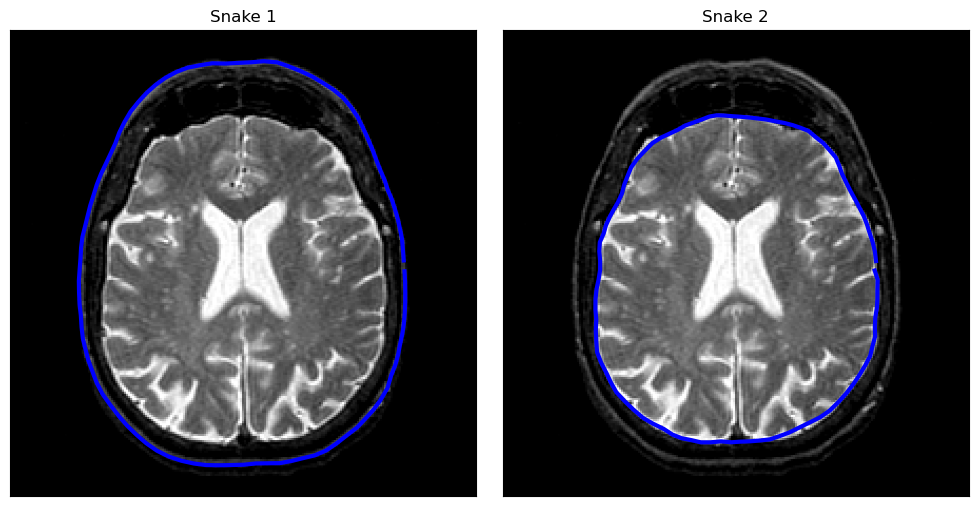

In [8]:
# Showcase the segmentation of the brain on brain.bmp

file_name = 'brain.bmp'

im = skio.imread(file_name)

snake1, snake2 = segment_brain(file_name)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].plot(snake1[:, 1], snake1[:, 0], '-b', lw=3)
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].set_title('Snake 1')

ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].plot(snake2[:, 1], snake2[:, 0], '-b', lw=3)
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].set_title('Snake 2')

plt.tight_layout()
plt.show()


## Implicit representation (Chan & Vese method)

The Chan-Vese method is a region-based active contour model used for image segmentation. It aims to separate an image into two regions: inside and outside a contour, based on intensity homogeneity. The contour evolves iteratively by minimizing an energy functional, which balances the fit of the regions and the smoothness of the contour.

### Parameter Explanation

We will use the `skimage.segmentation` implementation of the method:

**skimage.segmentation.chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=500, dt=0.5, init_level_set='checkerboard', extended_output=False)**


- **mu:** Regularization parameter that controls **smoothness** of the evolving contour.
- **lambda1:** Weight for the **inside** region of the contour.
- **lambda2:** Weight for the **outside** region of the contour.
- **tol:** **Convergence tolerance** that determines when the algorithm should stop.
- **max_iter:** Sets the **maximum number of iterations**.
- **dt:** Time step that controls the **speed** of the contour's evolution.
- **init_level_set:** `str` or `ndarray` (default = 'checkerboard'). Sets the **initial contour**.`'checkerboard'`: Default pattern with alternating 1s and 0s.
- **extended_output:** Whether to return additional information about the contour evolution.

#### Influence of the Initialization

The **initialization set (init set)** defines the starting contour for the Chan-Vese algorithm. 
Its role is crucial, as it determines where the segmentation process begins and how the contour evolves over iterations. 
A **well-chosen init set** helps the algorithm converge to the desired boundaries efficiently, while a poor initialization 
can lead to incorrect segmentation or longer computation times.

When choosing the init set:
1. **If the target region is well-defined** (e.g., a ventricle), we can use a tailored initialization, such as disks placed close to the target area.
2. **For more complex regions**, a random initialization may explore multiple areas and improve results.
3. **Global initializations**, like a checkerboard pattern, work well for larger or uniform structures but may struggle with small, localized objects.

The choice depends on the object size, shape, and location, as well as the noise level in the image.

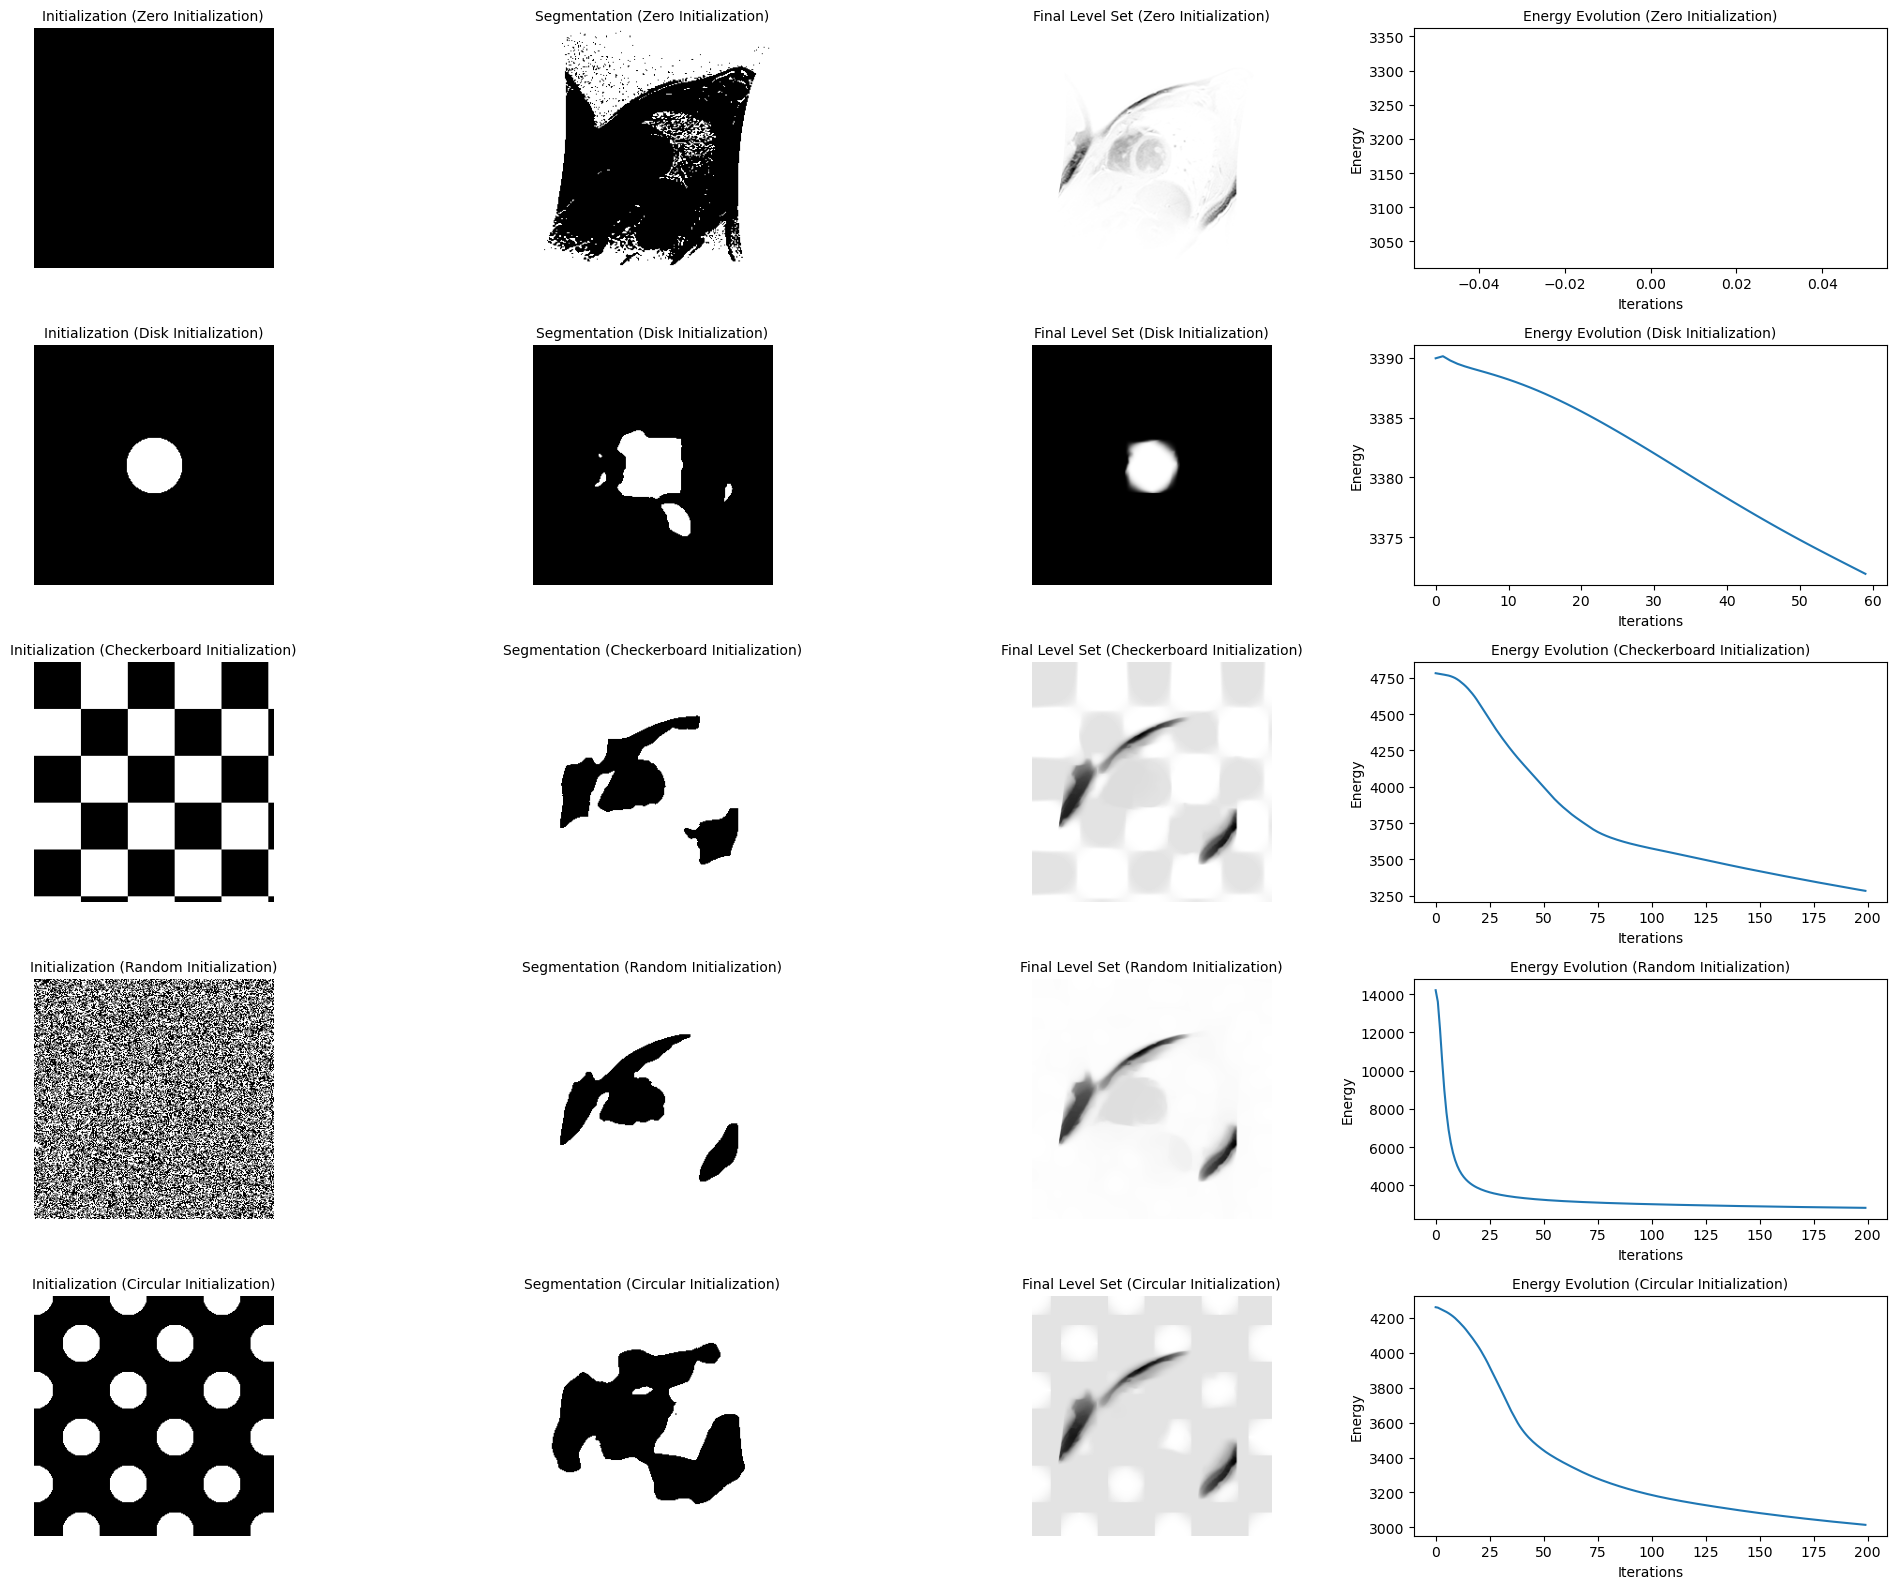

In [9]:
# Load the image
image = skio.imread('coeurIRM.bmp')
#image=image[:,:,1]
# Define initialization strategies
def disk_level_set(shape, center, radius):
    """Create a disk-shaped level set."""
    ls = np.zeros(shape, dtype=np.float32)
    rr, cc = draw_disk(center, radius,shape=shape)
    ls[rr, cc] = 1
    return ls

def circular_checkerboard_level_set(shape, radius=20, spacing=50):
    """Create a checkerboard-like pattern with circles."""
    ls = np.zeros(shape, dtype=np.float32)

    # Calculate number of circles to fit along the image dimensions
    num_rows = shape[0] // spacing + 1
    num_cols = shape[1] // spacing + 1

    # Place circles in a grid-like pattern
    for i in range(num_rows):
        for j in range(num_cols):
            # Alternate circles to mimic a checkerboard pattern
            if (i + j) % 2 == 0:
                rr, cc = draw_disk(((i * spacing), (j * spacing)), radius, shape=shape)
                ls[rr, cc] = 1

    return ls

def checkerboard_level_set(shape, square_size=50):
    """Create a checkerboard pattern with larger squares."""
    # Generate grid indices and scale them by square size
    grid = np.indices(shape) // square_size
    # Sum the indices along the axis and take modulo 2 to get the pattern
    return grid.sum(axis=0) % 2

def random_level_set(shape):
    """Create a noisy/random initialization."""
    return np.random.rand(*shape) > 0.5

# Create a dictionary with different initialization strategies
init_level_sets = {
    "Zero Initialization": np.zeros(image.shape),  # Blank initialization
    "Disk Initialization": disk_level_set(image.shape, center=(image.shape[0]//2, image.shape[1]//2), radius=30),  # Disk-shaped
    "Checkerboard Initialization": checkerboard_level_set(image.shape),  # Checkerboard pattern
    "Random Initialization": random_level_set(image.shape),  # Random noise
    "Circular Initialization": circular_checkerboard_level_set(image.shape, radius=20, spacing=50)
}

# Fixed value for mu
mu = 0.5

# Create a 4x4 grid of plots: 4 initializations × 4 outputs (init, segmentation, level set, energy plot)
fig, axes = plt.subplots(5, 4, figsize=(20, 16))

for row, (name, init_ls) in enumerate(init_level_sets.items()):
    # Apply Chan-Vese segmentation with the given initialization
    cv = segmentation.chan_vese(
        image,
        mu=mu,
        lambda1=5,
        lambda2=1,
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_ls,
        extended_output=True,
    )

    # Display the initialization set
    axes[row, 0].imshow(init_ls, cmap="gray")
    axes[row, 0].set_axis_off()
    axes[row, 0].set_title(f'Initialization ({name})', fontsize=10)

    # Display the segmented result
    axes[row, 1].imshow(cv[0], cmap="gray")
    axes[row, 1].set_axis_off()
    axes[row, 1].set_title(f'Segmentation ({name})', fontsize=10)

    # Display the final level set
    axes[row, 2].imshow(cv[1], cmap="gray")
    axes[row, 2].set_axis_off()
    axes[row, 2].set_title(f'Final Level Set ({name})', fontsize=10)

    # Plot the energy evolution
    axes[row, 3].plot(cv[2])
    axes[row, 3].set_title(f'Energy Evolution ({name})', fontsize=10)
    axes[row, 3].set_xlabel("Iterations")
    axes[row, 3].set_ylabel("Energy")

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

As we can observe, a single centered disk generally yields poor segmentation results. However, in the case of brain segmentation, especially when targeting the ventricles, it performs better compared to other methods. This is because the centered disk often aligns well with the structure of the ventricles. In this scenario, the other initializations tend to segment the brain outside of the skull. To segment the ventricles with the other initializations, we need to have brain images with pure brain structure only.

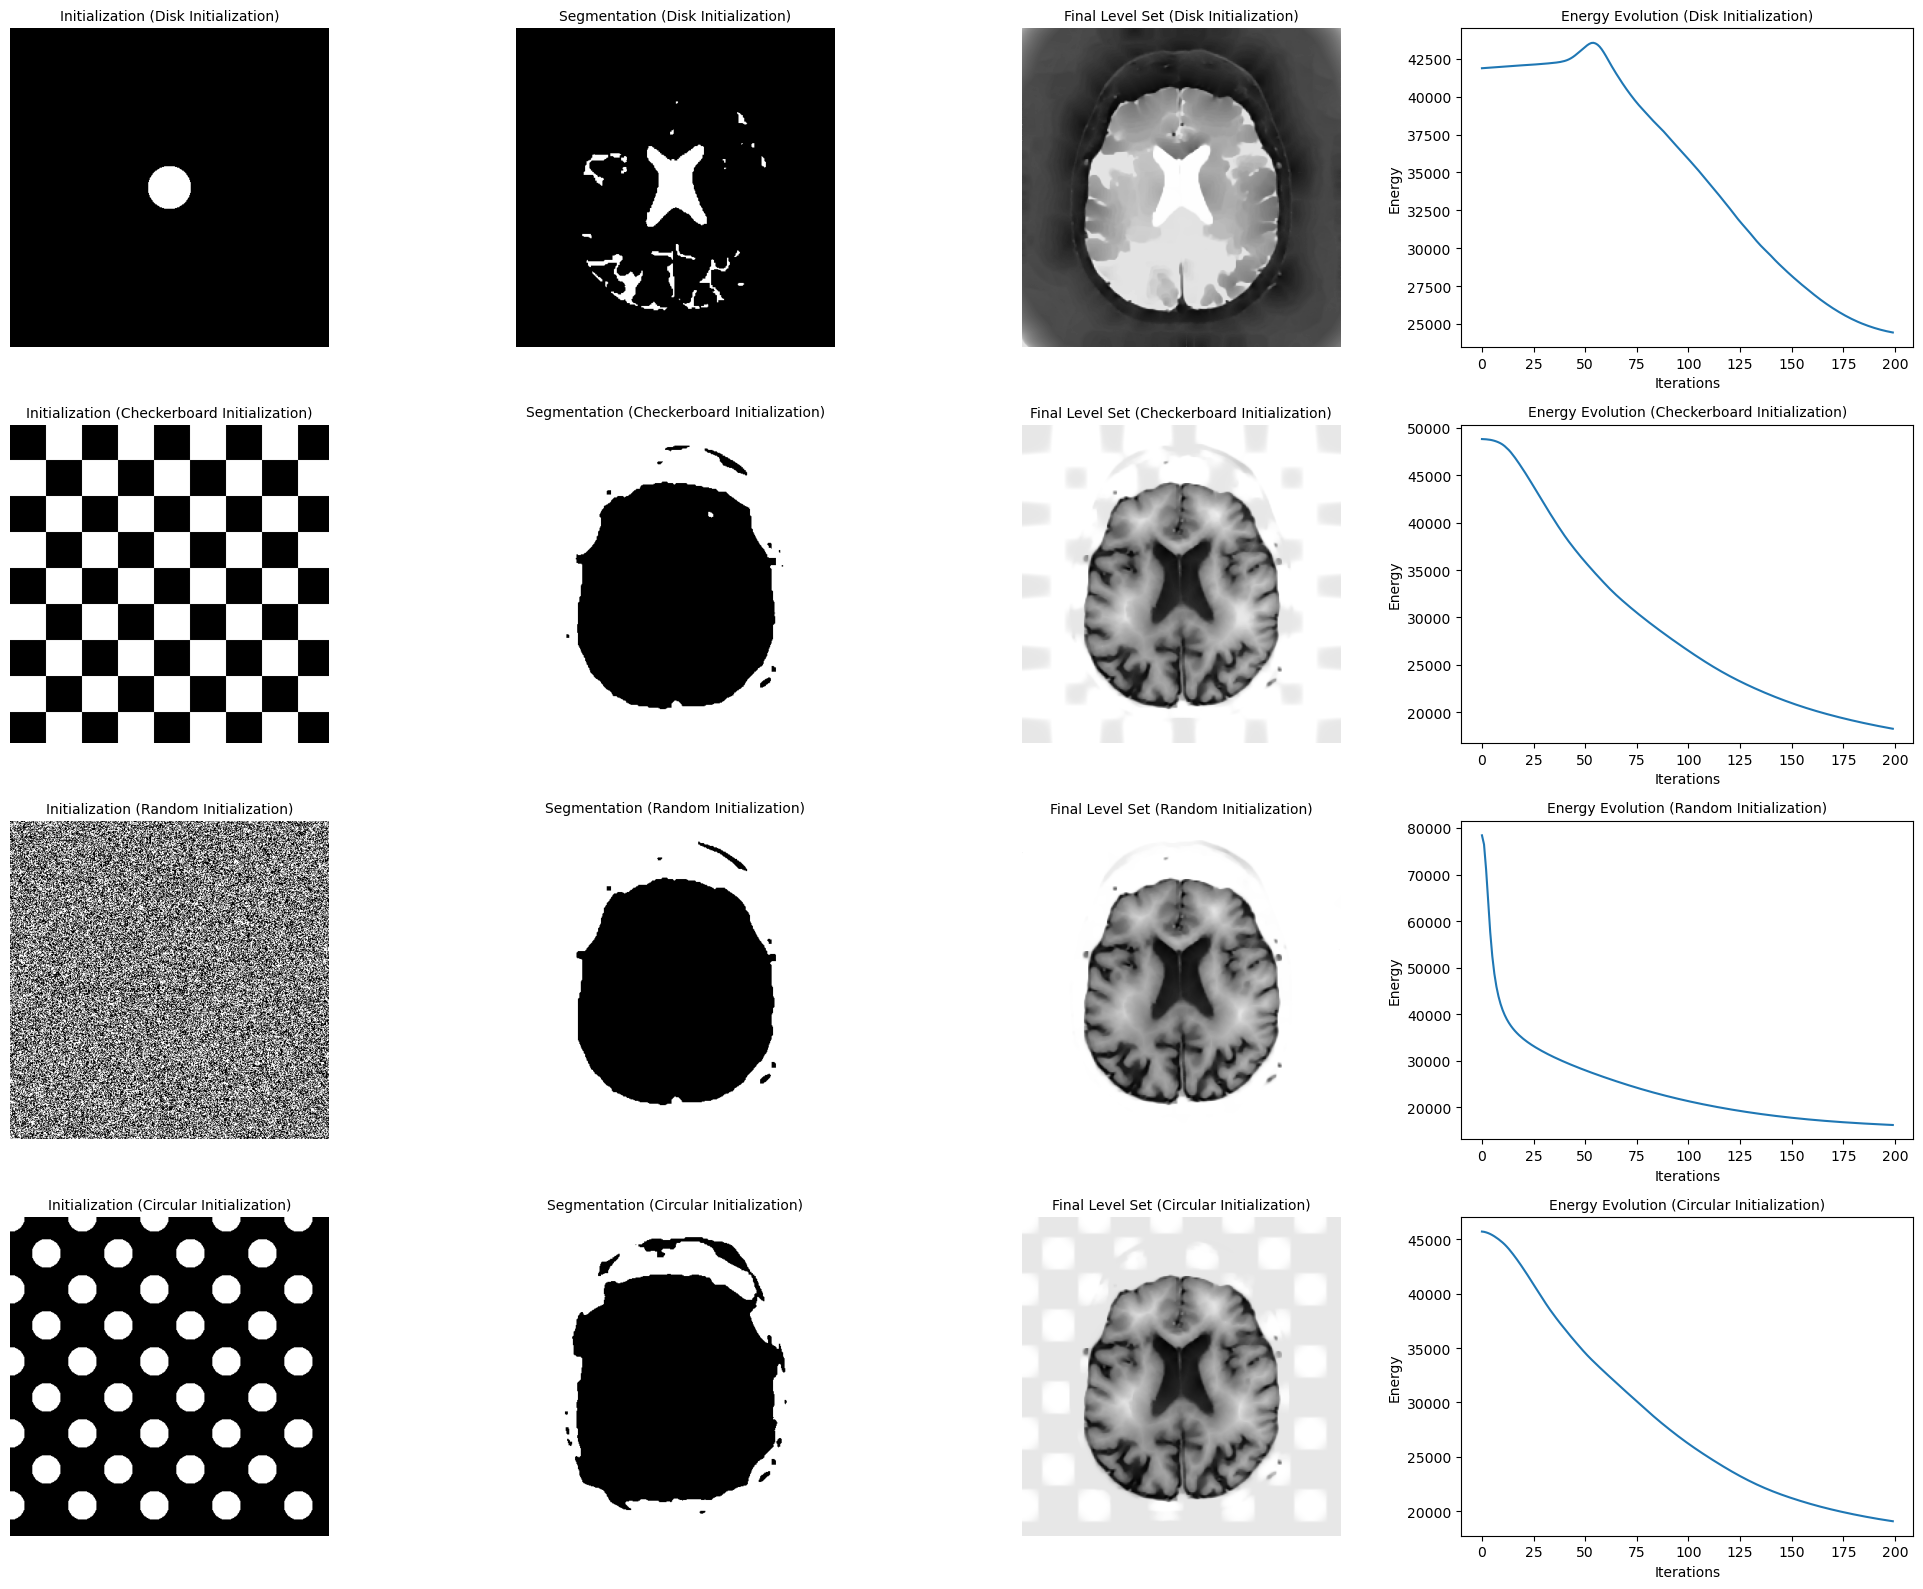

In [10]:
# Load the image
image = skio.imread('brain.bmp')
image=image[:,:,1]
# Create a dictionary with different initialization strategies
init_level_sets = {
    "Disk Initialization": disk_level_set(image.shape, center=(image.shape[0]//2, image.shape[1]//2), radius=30),  # Disk-shaped
    "Checkerboard Initialization": checkerboard_level_set(image.shape),  # Checkerboard pattern
    "Random Initialization": random_level_set(image.shape),  # Random noise
    "Circular Initialization": circular_checkerboard_level_set(image.shape, radius=20, spacing=50)
}

# Create a 4x4 grid of plots: 4 initializations × 4 outputs (init, segmentation, level set, energy plot)
fig, axes = plt.subplots(4, 4, figsize=(20, 16))

for row, (name, init_ls) in enumerate(init_level_sets.items()):
    # Apply Chan-Vese segmentation with the given initialization
    cv = segmentation.chan_vese(
        image,
        mu=mu,
        lambda1=5,
        lambda2=1,
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_ls,
        extended_output=True,
    )

    # Display the initialization set
    axes[row, 0].imshow(init_ls, cmap="gray")
    axes[row, 0].set_axis_off()
    axes[row, 0].set_title(f'Initialization ({name})', fontsize=10)

    # Display the segmented result
    axes[row, 1].imshow(cv[0], cmap="gray")
    axes[row, 1].set_axis_off()
    axes[row, 1].set_title(f'Segmentation ({name})', fontsize=10)

    # Display the final level set
    axes[row, 2].imshow(cv[1], cmap="gray")
    axes[row, 2].set_axis_off()
    axes[row, 2].set_title(f'Final Level Set ({name})', fontsize=10)

    # Plot the energy evolution
    axes[row, 3].plot(cv[2])
    axes[row, 3].set_title(f'Energy Evolution ({name})', fontsize=10)
    axes[row, 3].set_xlabel("Iterations")
    axes[row, 3].set_ylabel("Energy")

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

#### Influence of mu
In the Chan-Vese segmentation algorithm, the parameter `mu` significantly influences the smoothness of the segmented image's contours. A larger `mu` value increases the weight of the smoothness term in the energy functional, resulting in smoother boundaries that are less sensitive to noise and small features. Conversely, a smaller `mu` value allows for more complex and less smooth contours, which can capture finer details but may also lead to over-segmentation or artifacts from noise. This creates a trade-off between smoothness and fidelity in the segmentation results. For clean images, a lower `mu` may help preserve important structures, while a higher `mu` might be more effective in noisy images, providing robust boundaries. Thus, it is often necessary to experiment with different `mu` values to achieve the optimal balance for specific images and segmentation tasks, with visual inspection being crucial to assess the quality and accuracy of the segmentation.

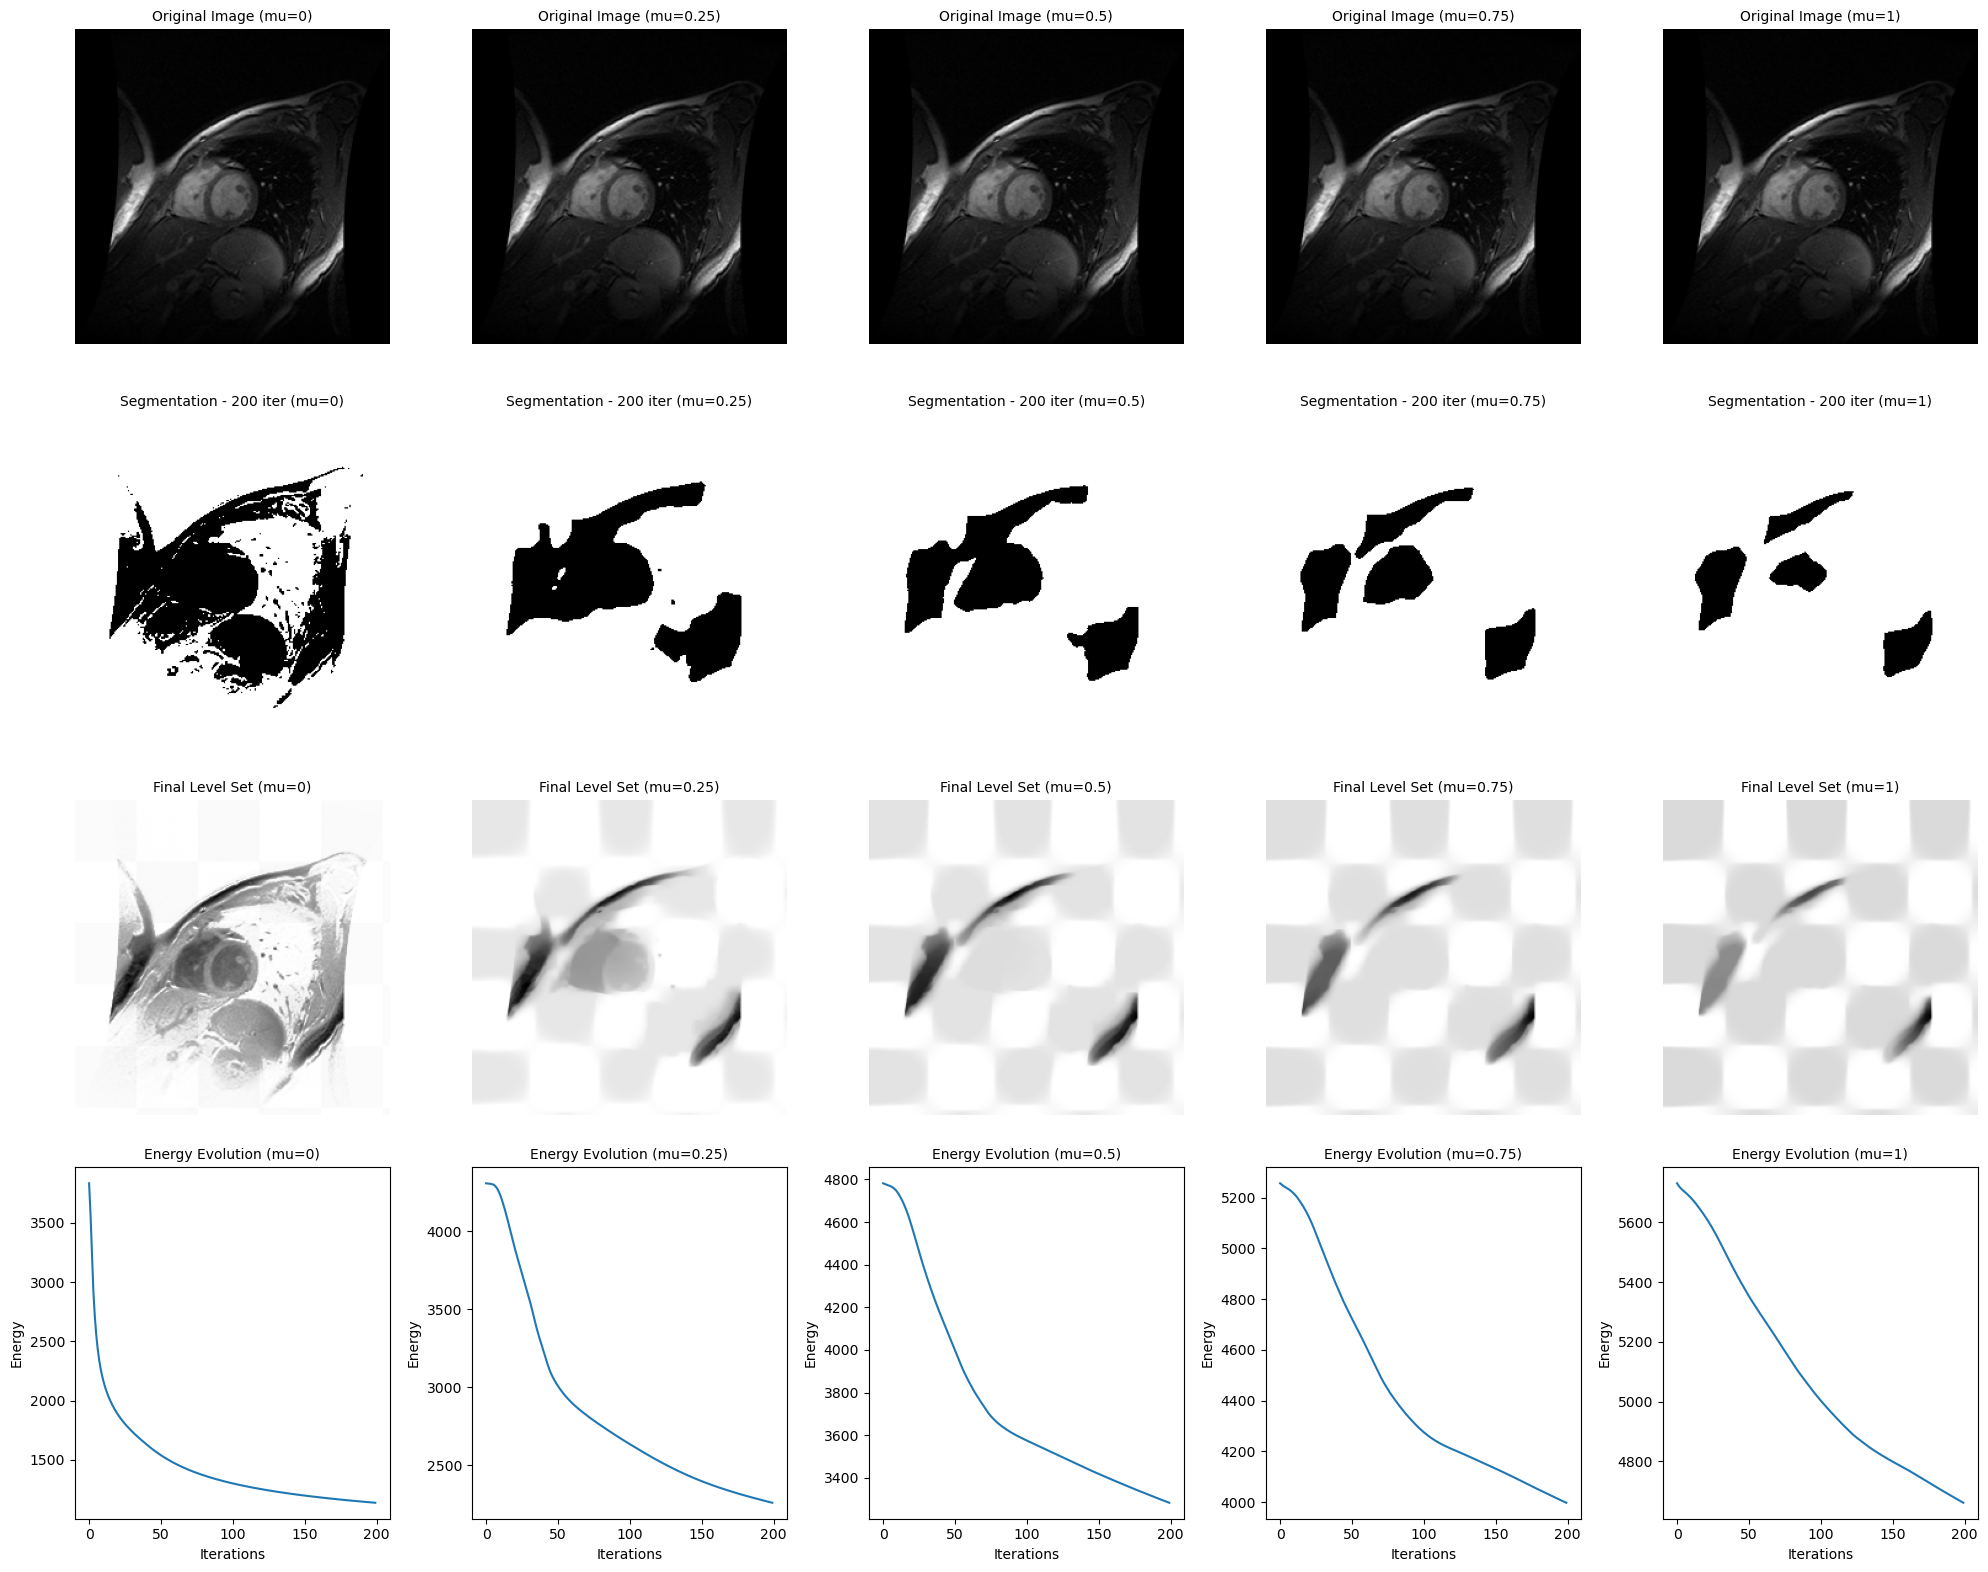

In [11]:
# Load the image
image = skio.imread('coeurIRM.bmp')

# Define different mu values for experimentation
mu_values = [0, 0.25, 0.5, 0.75, 1]
init_level_sets = checkerboard_level_set(image.shape)
# Create a 4x5 grid of plots (4 rows, 5 columns)
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i, m in enumerate(mu_values):
    # Apply Chan-Vese segmentation with different mu values
    cv = segmentation.chan_vese(
        image,
        m,
        lambda1=5,
        lambda2=1,
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_level_sets,  # Use "disk" as the initial level set
        extended_output=True,   # Returns (segmentation, level_set, energies)
    )

    # Display the original image
    axes[0, i].imshow(image, cmap="gray")
    axes[0, i].set_axis_off()
    axes[0, i].set_title(f"Original Image (mu={m})", fontsize=10)

    # Display the segmented result
    axes[1, i].imshow(cv[0], cmap="gray")
    axes[1, i].set_axis_off()
    axes[1, i].set_title(f'Segmentation - {len(cv[2])} iter (mu={m})', fontsize=10)

    # Display the final level set
    axes[2, i].imshow(cv[1], cmap="gray")
    axes[2, i].set_axis_off()
    axes[2, i].set_title(f"Final Level Set (mu={m})", fontsize=10)

    # Plot the energy evolution
    axes[3, i].plot(cv[2])
    axes[3, i].set_title(f"Energy Evolution (mu={m})", fontsize=10)
    axes[3, i].set_xlabel("Iterations")
    axes[3, i].set_ylabel("Energy")

# Adjust the layout to prevent overlap
fig.tight_layout()
plt.show()

#### Influence of 𝜆_1 and 𝜆_2

In the Chan-Vese segmentation algorithm, the parameters \(𝜆_1\) and \(𝜆_2\) control the contributions of the regions inside and outside the contour, respectively, thereby influencing the segmentation results. \(𝜆_1\) affects the foreground (True region), while \(𝜆_2\) influences the background (False region). If \(𝜆_1\) is less than \(𝜆_2\), the foreground can have a wider range of values, and vice versa. Adjusting these parameters can significantly impact the algorithm's performance; for instance, if \(𝜆_1\) is too high relative to \(𝜆_2\), the algorithm may become overly sensitive to noise, potentially including unwanted regions in the segmentation. On the other hand, if \(𝜆_2\) is disproportionately high, the algorithm might ignore relevant details within the target region. Thus, careful tuning of \(𝜆_1\) and \(𝜆_2\) is essential for achieving optimal segmentation, often requiring experimentation and visual evaluation to balance the segmentation's accuracy and robustness effectively.

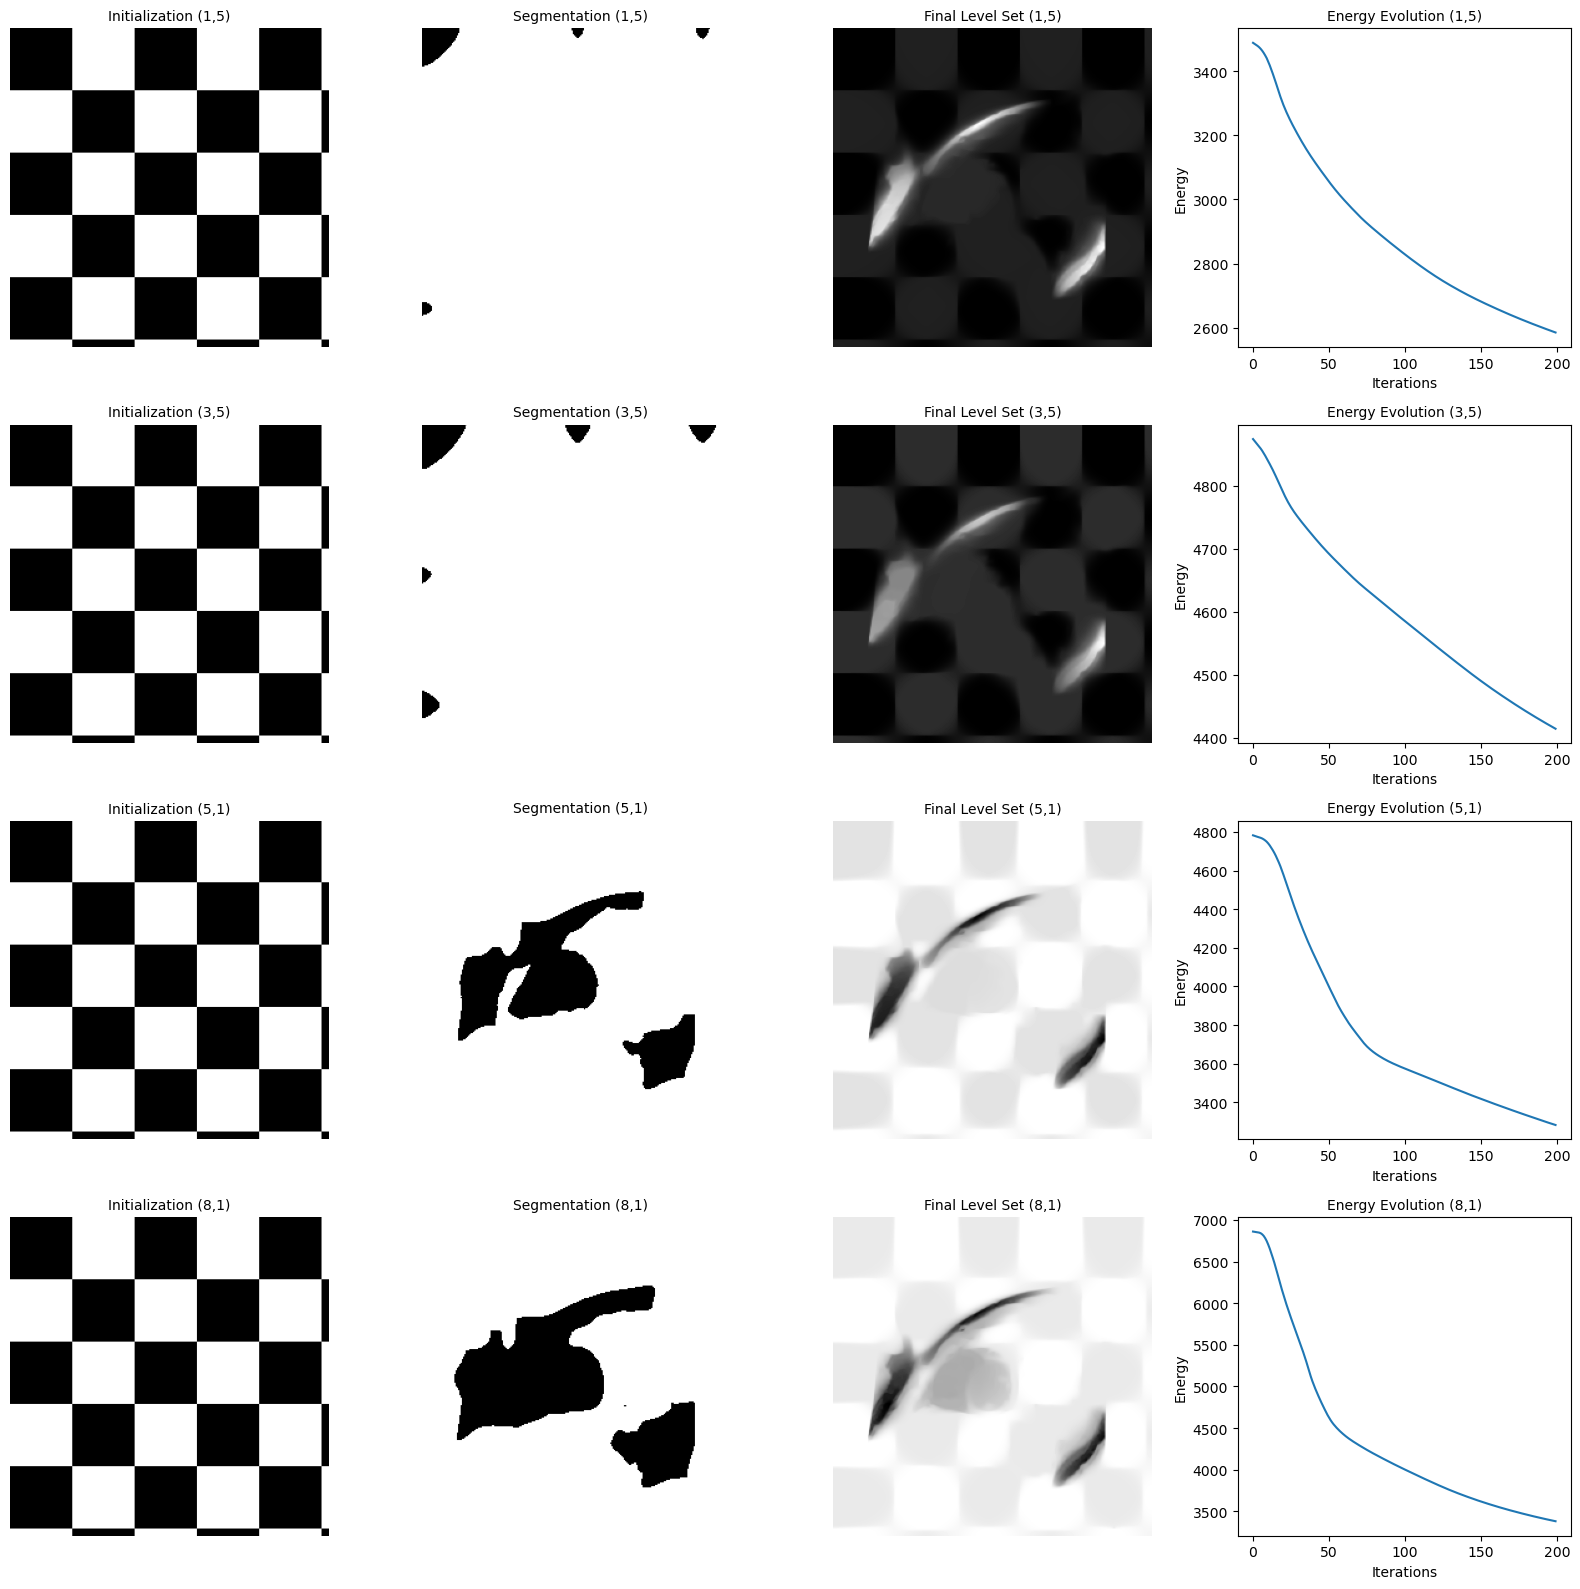

In [12]:
# Load the image
image = skio.imread('coeurIRM.bmp')

init_level_sets = checkerboard_level_set(image.shape)

# Fixed value for mu
mu = 0.5
L = {
    "(1,5)": (1,5),
      "(3,5)": (3,5),
    "(5,1)": (5,1),  # Disk-shaped
    "(8,1)": (8,1)  # Checkerboard pattern
}
# Create a 4x4 grid of plots: 4 initializations × 4 outputs (init, segmentation, level set, energy plot)
fig, axes = plt.subplots(4,4, figsize=(16, 16))

for row, (name, lymbda) in enumerate(L.items()):
    # Apply Chan-Vese segmentation with the given initialization
    cv = segmentation.chan_vese(
        image,
        mu=mu,
        lambda1=lymbda[0],
        lambda2=lymbda[1],
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_level_sets,
        extended_output=True,
    )

    # Display the initialization set
    axes[row, 0].imshow(init_level_sets, cmap="gray")
    axes[row, 0].set_axis_off()
    axes[row, 0].set_title(f'Initialization {name}', fontsize=10)

    # Display the segmented result
    axes[row, 1].imshow(cv[0], cmap="gray")
    axes[row, 1].set_axis_off()
    axes[row, 1].set_title(f'Segmentation {name}', fontsize=10)

    # Display the final level set
    axes[row, 2].imshow(cv[1], cmap="gray")
    axes[row, 2].set_axis_off()
    axes[row, 2].set_title(f'Final Level Set {name}', fontsize=10)

    # Plot the energy evolution
    axes[row, 3].plot(cv[2])
    axes[row, 3].set_title(f'Energy Evolution {name}', fontsize=10)
    axes[row, 3].set_xlabel("Iterations")
    axes[row, 3].set_ylabel("Energy")

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

### Segmentation

The challenge in segmenting skin lesions lies in the presence of hairs in most datasets. To remove the hairs, we use a pre-processing step that involves applying morphological closing with a disk-shaped structuring element of diameter 5. This helps eliminate small dark regions, specifically the hairs. Another challenge is that these lesions may exhibit some discontinuities, which can hinder the segmentation process. To address this, we apply morphological opening with a disk of diameter 3, which helps smooth the segmented regions and improves accuracy.

#### Segmentaion of skin lesions without using any pre_processing method.

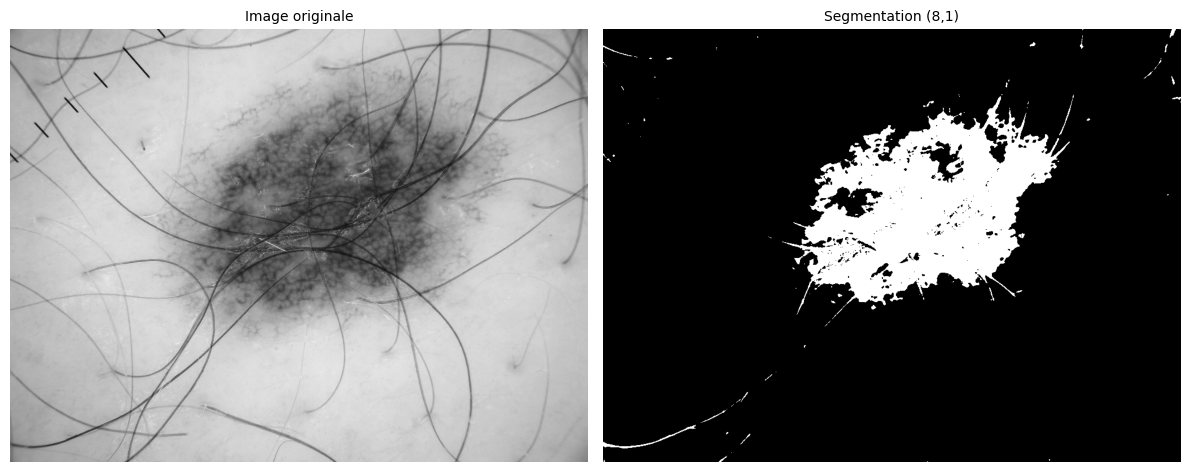

In [13]:
# Load the image
image = skio.imread('IM_000510.jpg')

# Use only the second channel (assuming the image is in RGB format)
image = image[:, :, 1]

# Fixed value for mu
mu = 0.5
# Create a dictionary with different initialization strategies
init_level_sets = disk_level_set(image.shape, center=(image.shape[0]//2, image.shape[1]//2), radius=30)
cv = segmentation.chan_vese(
        image,
        mu=mu,
        lambda1=8,
        lambda2=1,
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_level_sets,
        extended_output=True,
    )


fig, axes = plt.subplots(1, 2, figsize=(12, 12))  # Create subplots

# Display the initialization set
axes[0].imshow(image, cmap="gray")
axes[0].set_axis_off()
axes[0].set_title(f'Image originale', fontsize=10)

# Display the segmented result
axes[1].imshow(cv[0], cmap="gray")
axes[1].set_axis_off()
axes[1].set_title(f'Segmentation (8,1)', fontsize=10)

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

#### Segmentaion of skin lesions using a pre_processing method.

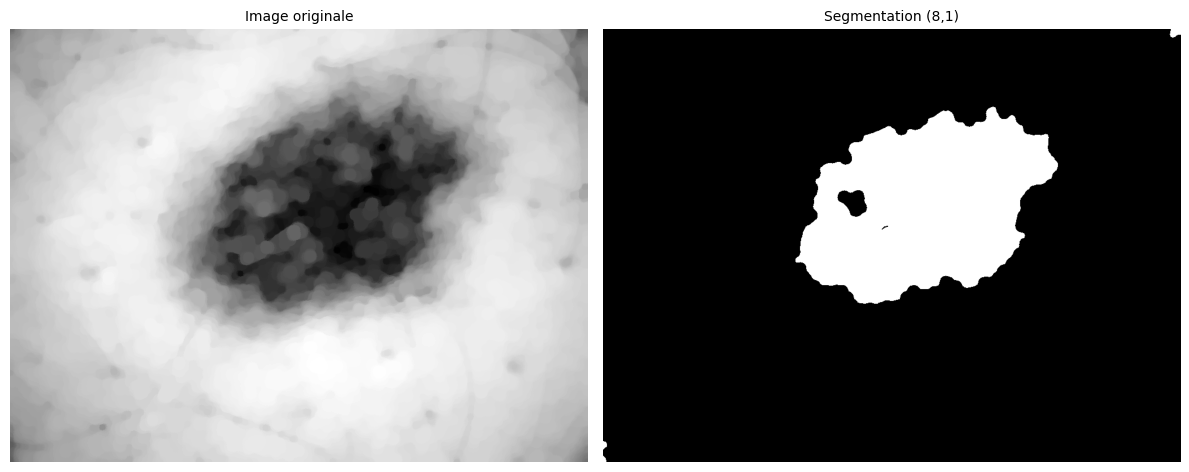

In [14]:
# Load the image
image = skio.imread('IM_000510.jpg')

# Use only the second channel (assuming the image is in RGB format)
image = image[:, :, 1]
se = disk(5)
image=morpho.closing(image,se)
se = disk(10)
image=morpho.opening(image,se)
# Fixed value for mu
mu = 0.5
# Create a dictionary with different initialization strategies
init_level_sets = disk_level_set(image.shape, center=(image.shape[0]//2, image.shape[1]//2), radius=30)
cv = segmentation.chan_vese(
        image,
        mu=mu,
        lambda1=8,
        lambda2=1,
        tol=1e-3,
        max_num_iter=200,
        dt=0.5,
        init_level_set=init_level_sets,
        extended_output=True,
    )

fig, axes = plt.subplots(1, 2, figsize=(12, 12))  # Create subplots

# Display the initialization set
axes[0].imshow(image, cmap="gray")
axes[0].set_axis_off()
axes[0].set_title(f'Image originale', fontsize=10)

# Display the segmented result
axes[1].imshow(cv[0], cmap="gray")
axes[1].set_axis_off()
axes[1].set_title(f'Segmentation (8,1)', fontsize=10)

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()